In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


In [2]:
data = pd.read_csv('Datasets/wine-clustering.csv')
data.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


In [4]:
data.describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [5]:
clean_data = data.copy()

In [6]:
# Handling outliers
for col in clean_data.columns:
    Q1 = clean_data[col].quantile(0.25)
    Q3 = clean_data[col].quantile(0.75)
    IQR = Q3-Q1
    low = Q1 - 1.5*IQR
    high = Q3 + 1.5*IQR
    clean_data[col] = clean_data[col].astype(float)
    median_val = clean_data[col].median()
    clean_data.loc[(clean_data[col] < low) | (clean_data[col] > high), col] = median_val

In [7]:
def initialize_centroids(x, k):
    random_index = np.random.permutation(x.shape[0])
    centroids = x[random_index[:k]]
    return centroids

In [8]:
def allocate_centroids(x, centroids):
    k = centroids.shape[0]
    m = x.shape[0]
    index = np.zeros(m, dtype=int)
    for i in range(m):
        distances = []
        for j in range(k):
            norm = np.linalg.norm(x[i] - centroids[j])
            distances.append(norm)
        index[i] = np.argmin(distances)
    return index


In [9]:
def update_centroids(x, index, k):
    n = x.shape[1]
    centroids = np.zeros((k, n))
    for i in range(k):
        points = x[index == i]
        if len(points) > 0:
            centroids[i] = np.mean(points, axis=0)
    return centroids

In [10]:
def fit_kmeans(x, k, max_iters):
    centroids = initialize_centroids(x, k)
    for _ in range(max_iters):
        index = allocate_centroids(x, centroids)
        new_centroids = update_centroids(x, index, k)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return centroids, index

In [11]:
def predict(data, centroids):
    return allocate_centroids(data, centroids)

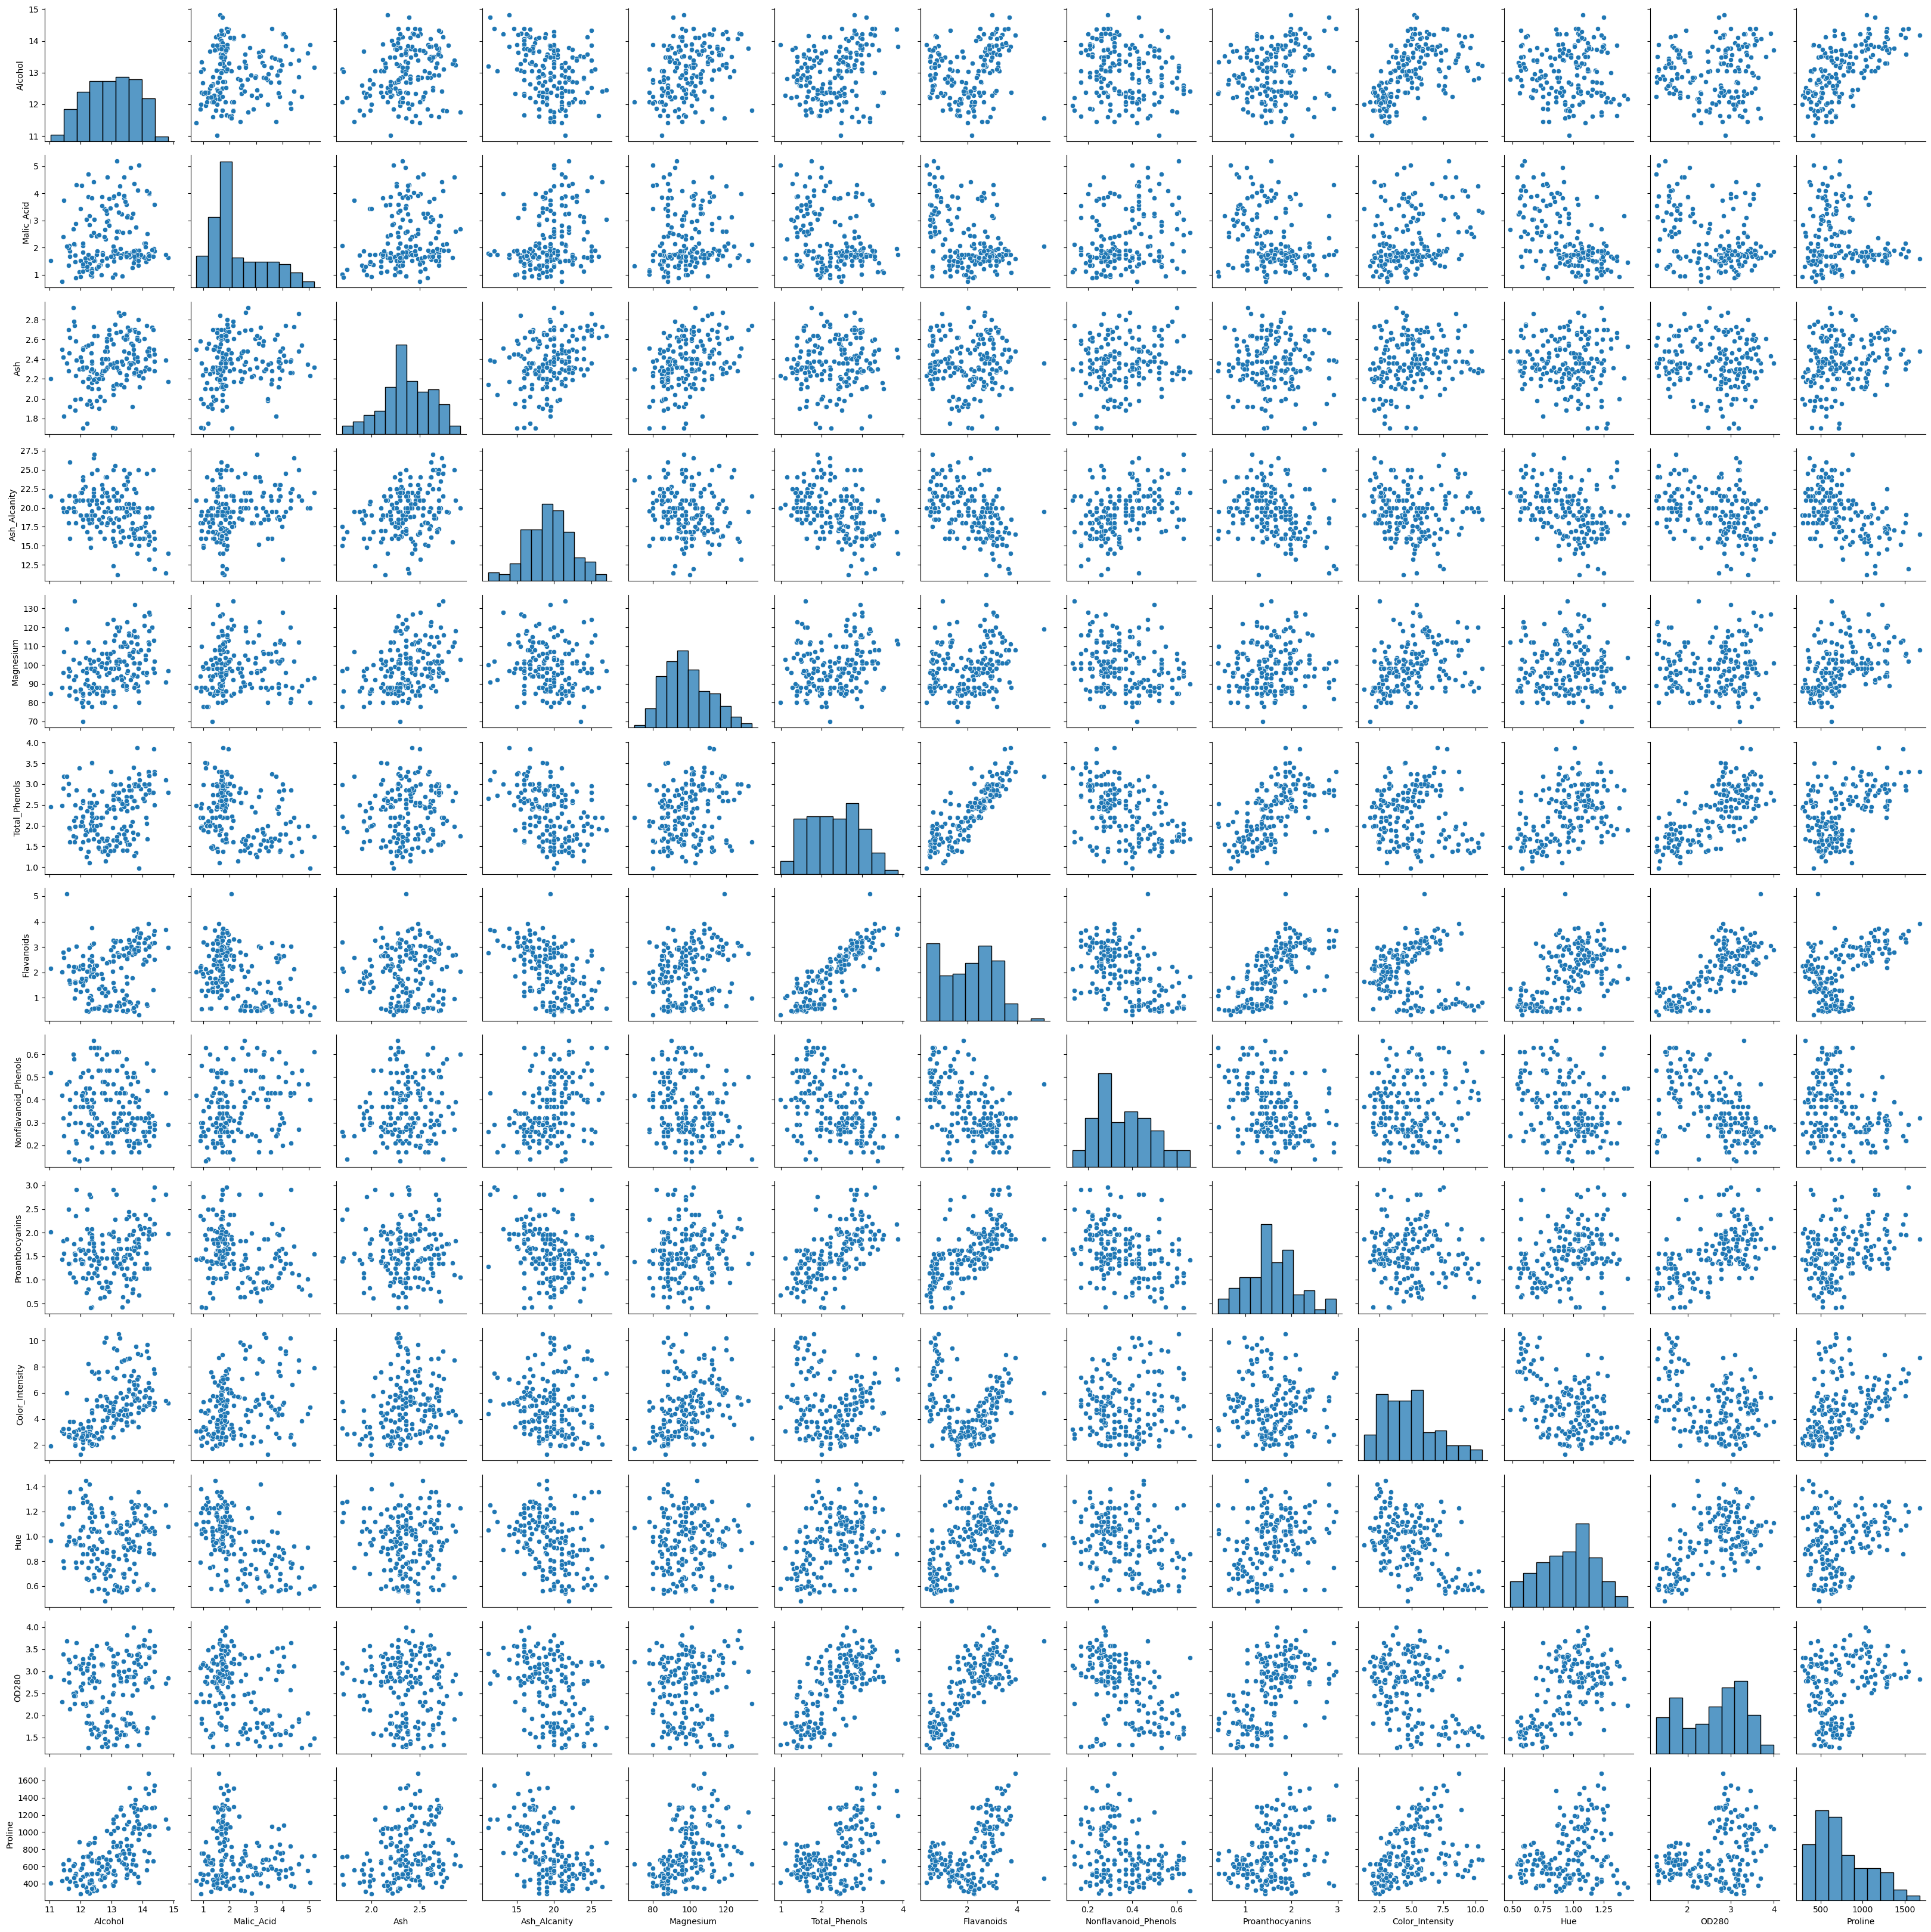

In [12]:
sns.pairplot(clean_data)
plt.tight_layout()
plt.show()

In [13]:
clean_data_std = clean_data.std(axis=0)
safe_std = np.where(clean_data_std == 0, 1, clean_data_std)
clean_scaled_data = (clean_data - clean_data.mean(axis=0))/safe_std

In [14]:
x = clean_scaled_data.to_numpy()

In [15]:
centroids, labels = fit_kmeans(x, 3, 10)
labels = predict(x, centroids)

In [16]:
# Using PCA to visualize clustering
pca = PCA(n_components=2)
pca_data = pca.fit_transform(x)
pca_centroids = pca.transform(centroids)

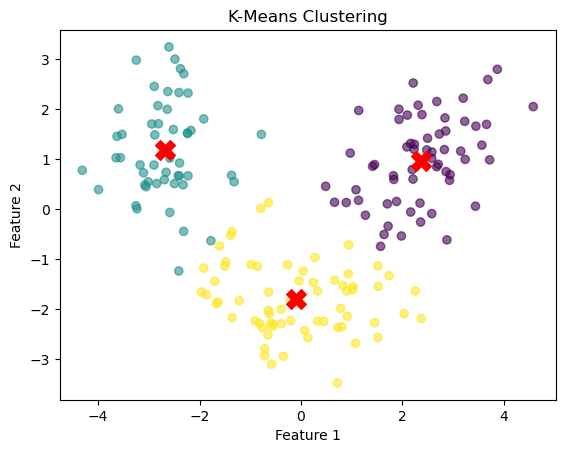

In [17]:
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(pca_centroids[:, 0], pca_centroids[:, 1], c='red', marker='X', s=200)
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [21]:
clean_data['Cluster'] = labels
clean_data.groupby('Cluster').mean()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
Cluster,,,,,,,,,,,,,
0,13.696557,2.005738,2.442295,17.118033,106.409836,2.853279,3.015246,0.291639,1.899836,5.500328,1.063934,3.172131,1102.901639
1,13.134118,3.161569,2.417647,21.241176,98.666667,1.683922,0.818824,0.451961,1.145882,6.696078,0.691961,1.696667,619.058824
2,12.254242,1.832045,2.245909,20.045455,91.439394,2.251515,2.053333,0.357121,1.592424,2.967424,1.052894,2.800758,516.636364
